In [48]:
import torch
import torchvision.transforms as transforms
import os
import spacy
from collections import Counter
from datasets import Dataset as HuggingFaceDataset
import pandas as pd
import pickle
import numpy as np
import string
import re

## Building the vocabulary

In [49]:
nlp = spacy.load("en_core_web_sm")

data_path = "data\\train"
dataset_files = []
word_counts = Counter()

# Get all HuggingFace Datasets
for listed_file in os.listdir(data_path):
    if listed_file.endswith(".arrow"):
        dataset_files.append(listed_file)


for i in range(int(len(dataset_files) * 0.8)):
    ds = HuggingFaceDataset.from_file(f"{data_path}\\{dataset_files[i]}")
    # Das zählt nur die Buchstaben und deren Häufigkeit
    for sentence in ds["prompt"]:
        doc = nlp(sentence)
        for token in doc:
            if token.is_alpha:
                word_counts[token.text] = word_counts.get(token.text, 0) + 1

vocab = [word for word, count in word_counts.most_common(30000)]
vocab_size = len(vocab) + 4  # Increment vocab_size by 4 for <UNK>, <SOS>, <PAD> and <EOS> tags

word2index = {word: i+4 for i, word in enumerate(vocab)}  # Shift indices by 4 for <UNK>, <SOS>, <PAD> and <EOS>
word2index["<UNK>"] = 0
word2index["<SOS>"] = 1
word2index["<EOS>"] = 2
word2index["<PAD>"] = 3

## Prompt Tokenization & Image Resizing

In [50]:
def tokenize(text):
    return [tok.text for tok in nlp(text)]

def tokens_to_indices(tokens):
    return [word2index["<SOS>"]] + [word2index.get(word, 0) for word in tokens] + [word2index["<EOS>"]]

def tokenize_and_index_prompts(prompts):
    return prompts.apply(tokenize).apply(tokens_to_indices).to_numpy()

In [51]:
def transform_images(images):
    transform = transforms.Compose([transforms.Resize((512,512)),
                                    transforms.ToTensor()])

    # Convert the PIL image to Torch tensor of size 512x512
    return images.apply(transform).to_numpy()

In [52]:
PREPROCESSED_DIR = "preprocessed"
os.makedirs(PREPROCESSED_DIR, exist_ok=True)  
total_index = 0
for i, file in enumerate(dataset_files):
        ds = pd.DataFrame(HuggingFaceDataset.from_file(f"{data_path}\\{file}"))
        
        transformed_images = transform_images(ds["image"])
        tokenized_prompts = tokenize_and_index_prompts(ds["prompt"])
        for i in range(len(ds)):
                np.save(f"{PREPROCESSED_DIR}\\image_{total_index}.npy", transformed_images[i])
                np.save(f"{PREPROCESSED_DIR}\\prompt_{total_index}.npy", tokenized_prompts[i])
                total_index += 1

In [53]:
with open("word2index.pkl", "wb") as f:
    pickle.dump(word2index, f)

In [54]:
def remove_punctuation(prompt):
    return  "".join([char for char in prompt if char not in string.punctuation])

In [55]:
dataset_files = []
data_path = "data\\train"
# Get all HuggingFace Datasets
for listed_file in os.listdir(data_path):
    if listed_file.endswith(".arrow"):
        dataset_files.append(listed_file)

RAW_PROMPTS = "raw_prompts.csv"
total_index = 0

prompts_df = pd.DataFrame({"prompt": []})
prev_prompts = pd.Series()
for file in dataset_files:
    ds = pd.DataFrame(HuggingFaceDataset.from_file(f"{data_path}/{file}"))
    ds["prompt"] = ds["prompt"].apply(remove_punctuation)
    prev_prompts = pd.concat([prev_prompts, ds["prompt"]], ignore_index=True)
    print(prev_prompts)
prompts_df["prompt"] = prev_prompts
prompts_df.to_csv(RAW_PROMPTS)



C:\Users\fruda\AppData\Local\Temp\ipykernel_14144\779889278.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prev_prompts = pd.Series()


0                      goddess portrait ismail inceoglu 
1                      goddess portrait ismail inceoglu 
2      portrait of king of candy mr harry haribo oil ...
3      super epic realistic nature photo trending on ...
4      super epic realistic nature photo trending on ...
                             ...                        
966    photo cartoon bd illustration comic manga pain...
967    photo of terrifying witch hyper detailed flowi...
968    highly detailed league of legends character po...
969    highly detailed league of legends character po...
970    highly detailed league of legends character po...
Length: 971, dtype: object
0                       goddess portrait ismail inceoglu 
1                       goddess portrait ismail inceoglu 
2       portrait of king of candy mr harry haribo oil ...
3       super epic realistic nature photo trending on ...
4       super epic realistic nature photo trending on ...
                              ...                       

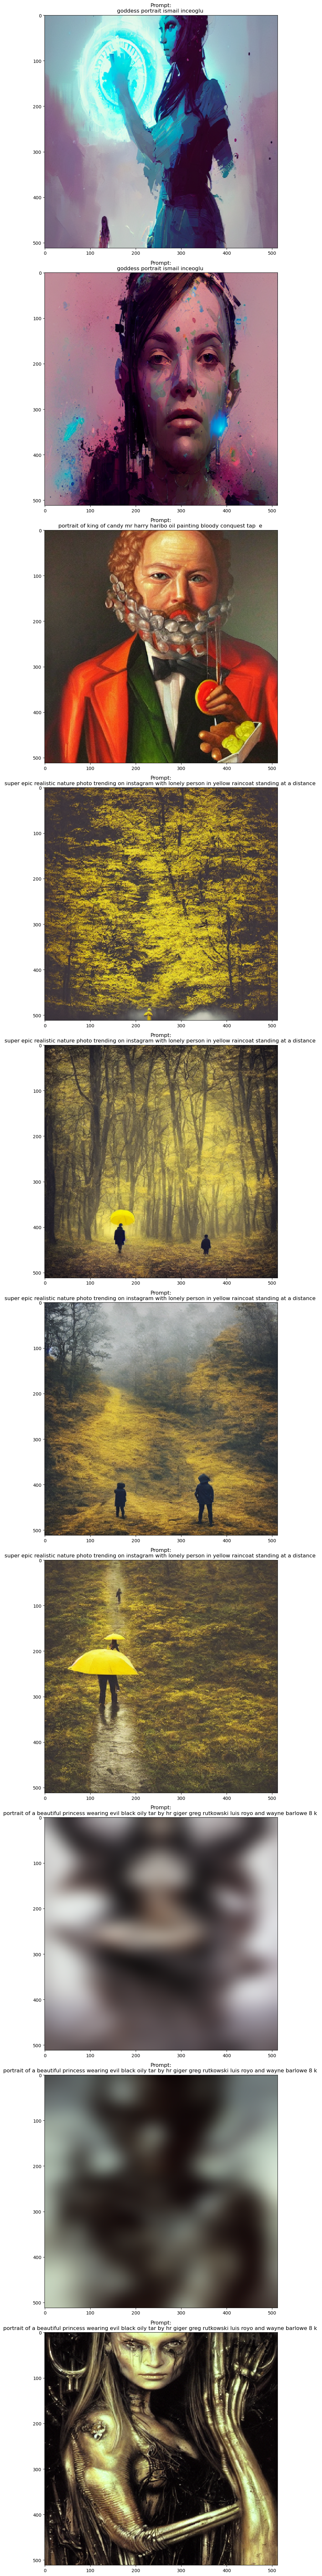

In [56]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

prompts = pd.read_csv("raw_prompts.csv")["prompt"]
num_images = 10  # Update this value to the total number of images
fig, axs = plt.subplots(num_images, 1, figsize=(8, 8 * num_images))  # num_images rows, 1 column

for i in range(num_images):
    image = np.load(f"preprocessed\\image_{i}.npy")
    image = np.transpose(image, (1, 2, 0))  # Transpose dimensions from (3, 512, 512) to (512, 512, 3)
    prompt = prompts[i]
    ax = axs[i]  # Select the current subplot
    ax.set_title(f"Prompt:\n{prompt}")
    ax.imshow(image, interpolation="nearest")

plt.tight_layout()
plt.show()
